In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../secondMMRintData/EritasEtAlTest.csv')

In [3]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [4]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 6.02 s, sys: 44.5 ms, total: 6.07 s
Wall time: 6.06 s


In [38]:
#removed twoMMRs 
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
megno = ['MEGNO', 'MEGNOstd']
threeBR = ['threeBRfillfac', 'threeBRfillstd']
#what is being used to train

twoBRwidth = ['MMRstrengthWnear','MMRstrengthWfar','MMRstrengthWouter','twoMMRstrengthWnear','twoMMRstrengthWfar','twoMMRstrengthWouter']
twoBRinW = ['MMRinWidnear','MMRinWidfar','MMRinWidouter','twoMMRinWidnear','twoMMRinWidfar','twoMMRinWidouter']

features = near + far + outer + megno + threeBR + twoBRwidth +twoBRinW
OGfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']
Oldfeatures = near + far + outer + megno + threeBR 
threeMegno = threeBR+OGfeatures
MMRDATA = ['threeBRfillfac','MMRstrengthnear','MMRstrengthfar','MMRstrengthouter','twoMMRstrengthnear','twoMMRstrengthfar','twoMMRstrengthouter','EMcrossnear','EMcrossfar','EMcrossouter']+twoBRwidth
#, 'EMcrossnear','EMcrossfar','EMcrossouter'

SEC = ['chiSec12','chiSec23']

Test = SEC+MMRDATA

In [7]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [8]:
filtData

,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,twoMMRstrengthWnear,...,MEGNOstd,threeBRfillfac,threeBRfillstd,chiSec12,chiSec23,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,0,0.221502,0.0,0.0,0.098431,9.878834e-03,0.0,0.013615,1.0,7.075038e-03,...,0.0,0.447352,0.0,0.974706,0.025294,True,False,1.235665e+07,8.315223e+07,0
1,1,0.190647,0.0,0.0,0.009185,1.703367e-03,1.0,0.002670,1.0,4.107756e-05,...,0.0,0.387809,0.0,0.069950,0.930050,True,False,1.348749e+05,2.133072e+05,0
2,2,0.125660,0.0,0.0,0.426660,1.310313e-01,0.0,0.033117,0.0,2.216802e-02,...,0.0,0.892770,0.0,0.999966,0.000034,True,False,1.276428e+04,9.321863e+03,0
3,3,0.216684,0.0,0.0,0.002876,1.857040e-07,1.0,0.000209,1.0,1.511511e-07,...,0.0,0.083149,0.0,0.329016,0.670984,True,True,1.000000e+09,1.000000e+09,0
4,4,0.024455,0.0,0.0,0.423830,1.145611e-01,0.0,0.003860,0.0,5.812017e-03,...,0.0,35.774018,0.0,0.121660,0.878340,True,False,8.791890e+01,8.791890e+01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,138538,0.082222,0.0,0.0,0.447117,2.475049e-02,0.0,0.007770,1.0,7.892905e-03,...,0.0,0.776506,0.0,0.026189,0.973811,True,False,6.990387e+05,8.267916e+05,0
138539,138539,0.251338,0.0,0.0,0.749336,1.701463e-03,0.0,0.002360,1.0,1.041106e-03,...,0.0,0.206226,0.0,0.100165,0.899835,True,False,3.075749e+08,6.576003e+08,0
138540,138540,0.131799,0.0,0.0,0.324267,2.940005e-02,0.0,0.017718,1.0,1.722615e-02,...,0.0,0.890745,0.0,0.996531,0.003469,True,False,1.193822e+07,3.363291e+07,0
138541,138541,0.209454,0.0,0.0,1.205802,5.207774e-02,0.0,0.033013,0.0,5.796469e-02,...,0.0,0.375527,0.0,0.998344,0.001656,True,False,2.064407e+08,4.316851e+07,0


In [9]:
scrambled = filtData.sample(frac=1)

In [10]:
scrambled = scrambled.reset_index()

In [11]:
scrambled

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,...,MEGNOstd,threeBRfillfac,threeBRfillstd,chiSec12,chiSec23,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,223,223,0.165222,0.0,0.0,0.030181,0.001907,1.0,0.002559,1.0,...,0.0,0.185978,0.0,0.395724,0.604276,True,True,1.000000e+09,1.000000e+09,0
1,37109,37109,0.218903,0.0,0.0,0.087291,0.009061,1.0,0.008985,1.0,...,0.0,0.145085,0.0,0.787972,0.212028,True,False,9.319986e+07,3.201222e+07,0
2,22318,22318,0.102310,0.0,0.0,0.036881,0.010138,0.0,0.001036,1.0,...,0.0,0.081586,0.0,0.606994,0.393006,True,False,8.916242e+05,1.086984e+06,0
3,123288,123288,0.040299,0.0,0.0,0.018592,0.011346,1.0,0.001113,1.0,...,0.0,4.208068,0.0,0.040441,0.959559,True,False,7.150118e+05,9.772348e+04,0
4,79787,79787,0.110898,0.0,0.0,0.230759,0.040039,0.0,0.015508,1.0,...,0.0,0.170613,0.0,0.994479,0.005521,True,True,1.000000e+09,1.000000e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138538,26968,26968,0.126376,0.0,0.0,0.088107,0.011661,0.0,0.005431,1.0,...,0.0,0.374291,0.0,0.970103,0.029897,True,False,4.767417e+05,6.258894e+05,0
138539,98972,98972,0.130595,0.0,0.0,0.905356,0.045023,0.0,0.025744,1.0,...,0.0,0.661625,0.0,0.997665,0.002335,True,True,1.000000e+09,1.000000e+09,0
138540,133674,133674,0.252966,0.0,0.0,0.241829,0.011880,0.0,0.008617,1.0,...,0.0,0.011457,0.0,0.982543,0.017457,True,False,4.316485e+07,7.589345e+07,0
138541,62746,62746,0.100417,0.0,0.0,0.376499,0.044331,0.0,0.006077,1.0,...,0.0,0.268713,0.0,0.886060,0.113940,True,False,6.410556e+04,1.020801e+03,0


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [12]:
dataset['prelimStable'].value_counts()[False]

KeyError: False

In [13]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]

# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [14]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [15]:
realTest = test.loc[test['prelimStable']==True]

In [16]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [17]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
train

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRinWidnear,MMRstrengthWnear,twoMMRinWidnear,...,MEGNOstd,threeBRfillfac,threeBRfillstd,chiSec12,chiSec23,prelimStable,Stable,instability_time,shadow_instability_time,hasnull
0,223,223,0.165222,0.0,0.0,0.030181,0.001907,1.0,0.002559,1.0,...,0.0,0.185978,0.0,0.395724,0.604276,True,True,1.000000e+09,1.000000e+09,0
1,37109,37109,0.218903,0.0,0.0,0.087291,0.009061,1.0,0.008985,1.0,...,0.0,0.145085,0.0,0.787972,0.212028,True,False,9.319986e+07,3.201222e+07,0
2,22318,22318,0.102310,0.0,0.0,0.036881,0.010138,0.0,0.001036,1.0,...,0.0,0.081586,0.0,0.606994,0.393006,True,False,8.916242e+05,1.086984e+06,0
3,123288,123288,0.040299,0.0,0.0,0.018592,0.011346,1.0,0.001113,1.0,...,0.0,4.208068,0.0,0.040441,0.959559,True,False,7.150118e+05,9.772348e+04,0
4,79787,79787,0.110898,0.0,0.0,0.230759,0.040039,0.0,0.015508,1.0,...,0.0,0.170613,0.0,0.994479,0.005521,True,True,1.000000e+09,1.000000e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110829,33456,33456,0.122557,0.0,0.0,0.103798,0.051887,0.0,0.014954,0.0,...,0.0,0.573812,0.0,0.966351,0.033649,True,False,1.668807e+04,6.739410e+03,0
110830,7091,7091,0.059952,0.0,0.0,0.288156,0.012763,0.0,0.002908,1.0,...,0.0,1.327607,0.0,0.973972,0.026028,True,False,3.099713e+03,3.428768e+03,0
110831,129428,129428,0.109208,0.0,0.0,0.452759,0.025875,0.0,0.010966,1.0,...,0.0,0.693496,0.0,0.257692,0.742308,True,True,1.000000e+09,1.000000e+09,0
110832,80726,80726,0.087164,0.0,0.0,0.484832,0.037555,0.0,0.003870,1.0,...,0.0,2.041293,0.0,0.078149,0.921851,True,False,1.618688e+04,8.695103e+03,0


In [43]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [44]:
testModel.fit(train[MMRDATA], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [45]:
resPred = testModel.predict_proba(tT[MMRDATA])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[MMRDATA]), tT["Stable"]))

0.9451042270652295
0.8552188552188552


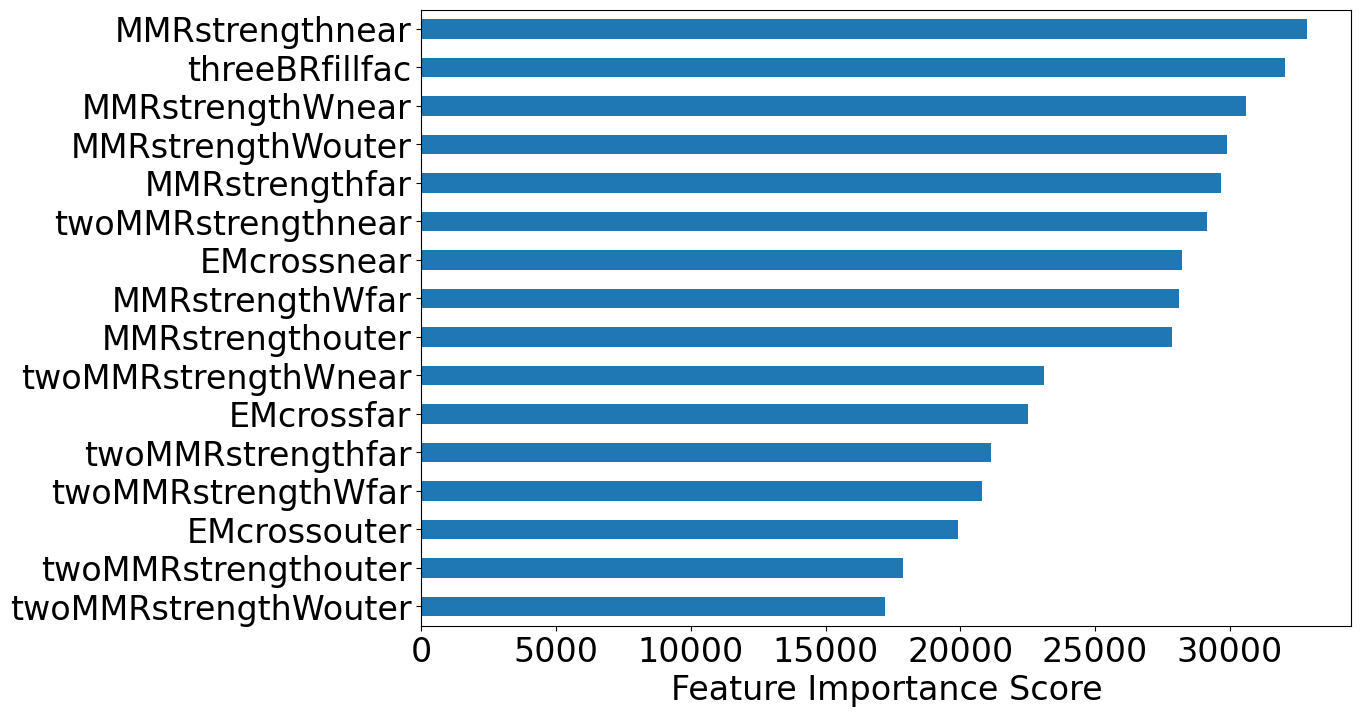

In [46]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0.0, 20.0)

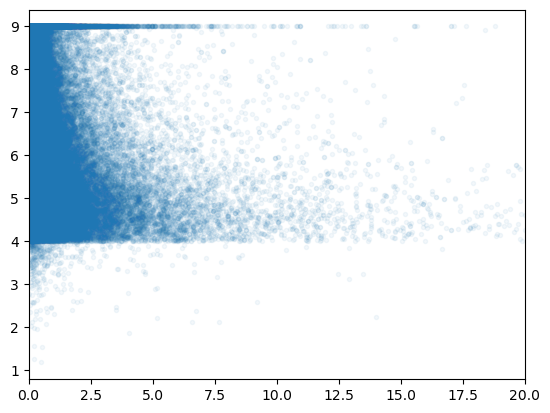

In [34]:
plt.plot(train['threeBRfillfac'],np.log10(train['instability_time']), '.', alpha = .05)
ax = plt.gca()
ax.set_xlim([0,20])


In [101]:
which = (filtData['MMRstrengthnear']+filtData['MMRstrengthfar']+filtData['MMRstrengthouter'])/3

In [102]:
filtData['avarage']=which

/tmp/ipykernel_7671/3581258837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtData['avarage']=which


In [135]:
np.median(filtData['avarage'])

0.09772070340039676

In [150]:
plot = filtData.drop(filtData[filtData['avarage'] >.5].index)

/tmp/ipykernel_7671/2409900035.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['avarage'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.5)


(4.0, 9.0)

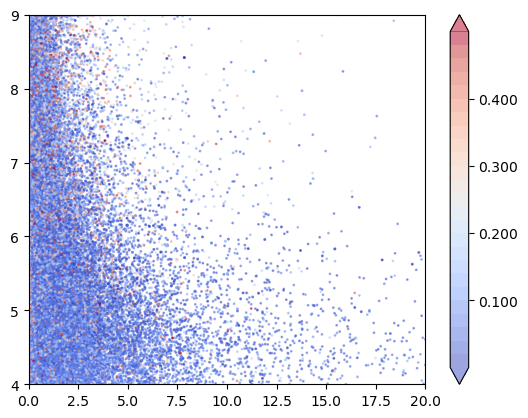

In [154]:
ax = plt.axes()
plt.scatter(plot['threeBRfillfac'],np.log10(plot['instability_time']), s=1, c=((plot['avarage'])), cmap=plt.cm.get_cmap("coolwarm",25),alpha=0.5)
cbar = plt.colorbar(orientation="vertical", extend="both",
                   pad=0.05, shrink=1, aspect=20, format="%.3f")
ax.set_xlim([0,20])
ax.set_ylim([4,9])

(0.0, 30.0)

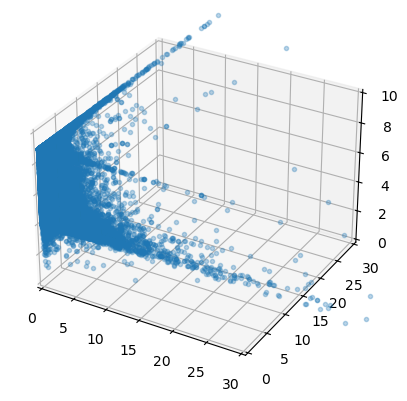

In [53]:
ax = plt.axes(projection='3d')
ax.plot3D(train['threeBRfillfac'], train['MMRstrengthnear'],np.log10(train['instability_time']),'.', alpha = 0.3)
ax.set_xlim([0,30])
ax.set_zlim([0,10])
ax.set_ylim([0,30])

In [30]:
newModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 45, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 450,
                         scale_pos_weight=resultBalance)

In [31]:
newModel.fit(train[features], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=45, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=450, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
resPred = newModel.predict_proba(realTest[features])[:,1]
newAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
newacc = accuracy_score(newModel.predict(realTest[features]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(newModel.predict(realTest[features]), realTest["Stable"]))

0.9716631946863221
0.9165891347437402


In [33]:
OldModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 4,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [34]:
OldModel.fit(train[Oldfeatures], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
resPred = OldModel.predict_proba(realTest[Oldfeatures])[:,1]
oldAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oldacc = accuracy_score(OldModel.predict(realTest[Oldfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(OldModel.predict(realTest[Oldfeatures]), realTest["Stable"]))

0.9706890735767606
0.9150519800978925


In [101]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         scale_pos_weight=resultBalance)
oneModel.fit(train[OGfeatures], train["Stable"])
resPred = oneModel.predict_proba(realTest[OGfeatures])[:,1]
oneMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oneMMRacc = accuracy_score(oneModel.predict(realTest[OGfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest[OGfeatures]), realTest["Stable"]))

0.9531695575960055
0.8871809392823915


In [102]:
print('OG compaired to improved model')
print(f'decrease in AOC: {((1-oneMMRAUC)-(1-newAUC))/(1-oneMMRAUC)}')
print(f'decrease in error: {((1-oneMMRacc)-(1-newacc))/(1-oneMMRacc)}')

OG compaired to improved model
decrease in AOC: 0.3328231447326524
decrease in error: 0.211903908210828


In [103]:
print('new compaired to old model')
print(f'decrease in AOC: {((1-oldAUC)-(1-newAUC))/(1-oldAUC)}')
print(f'decrease in error: {((1-oldacc)-(1-newacc))/(1-oldacc)}')

new compaired to old model
decrease in AOC: 0.017134652518024613
decrease in error: 0.011690647482013613


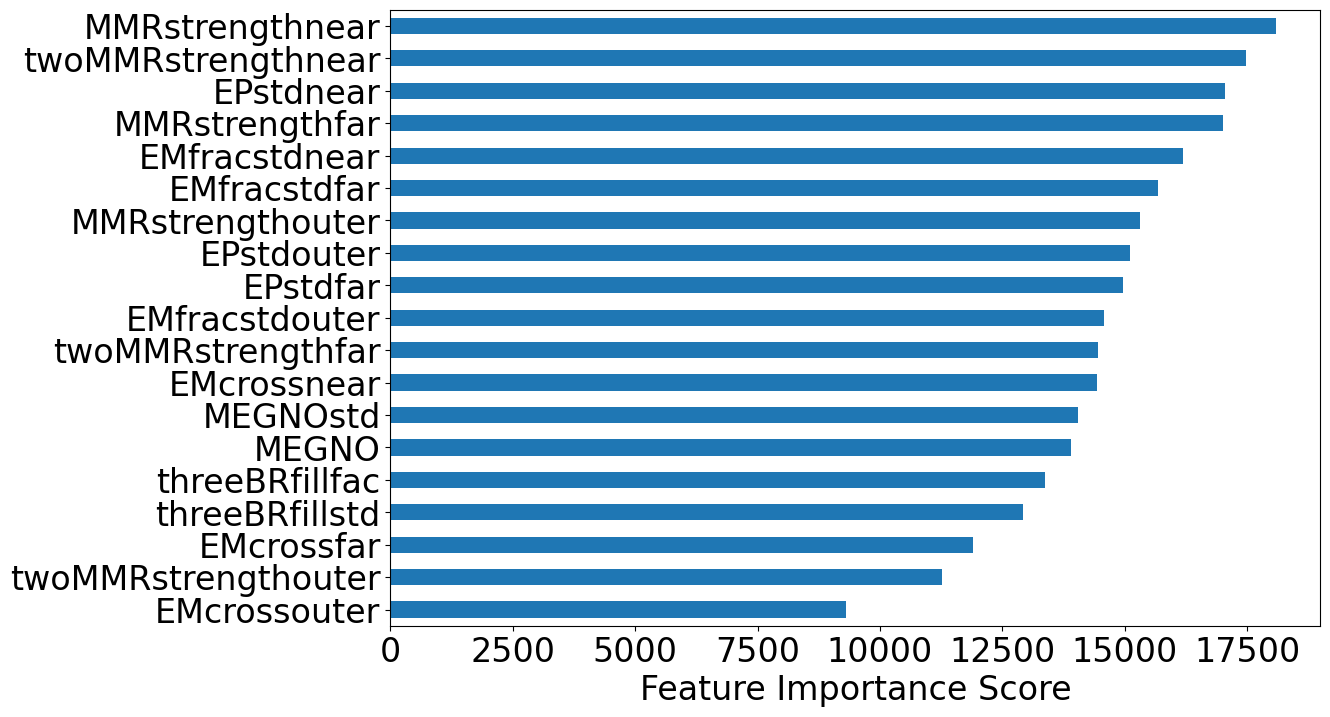

In [37]:
feat_imp = pd.Series(OldModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

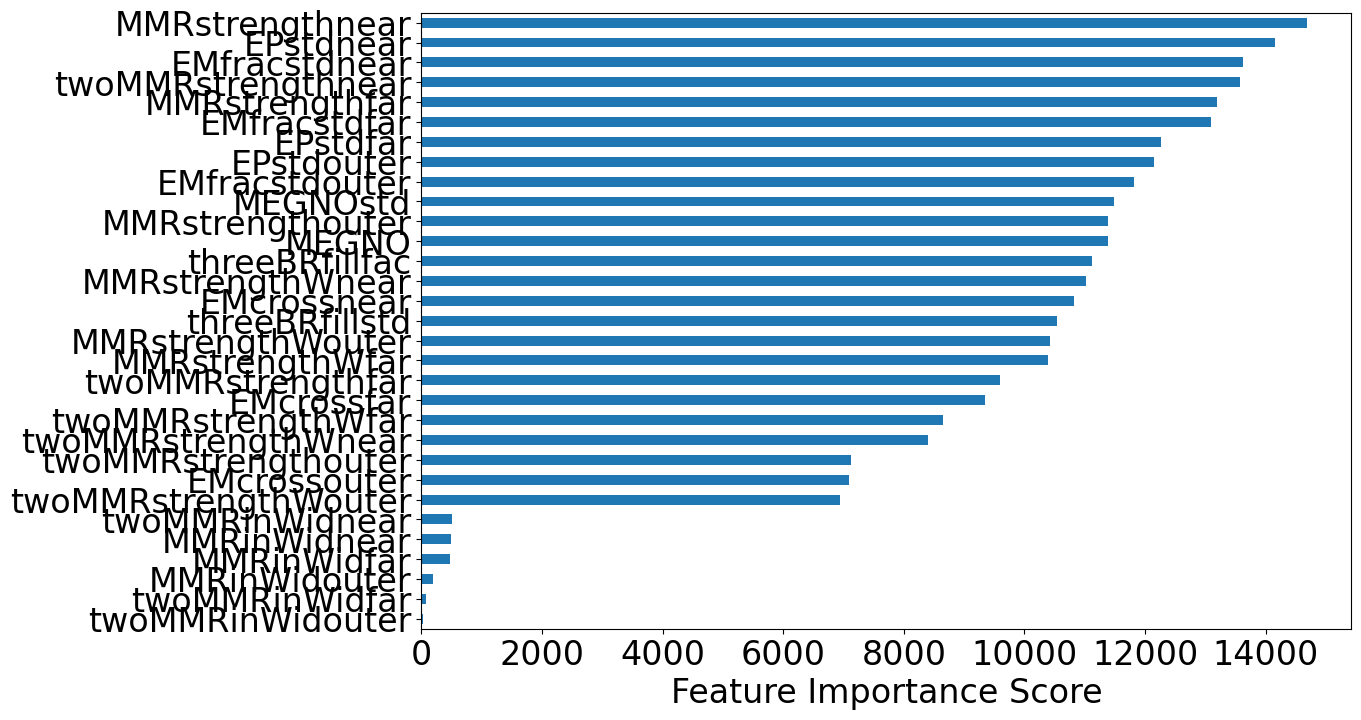

In [36]:
feat_imp = pd.Series(newModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0.0, 50.0)

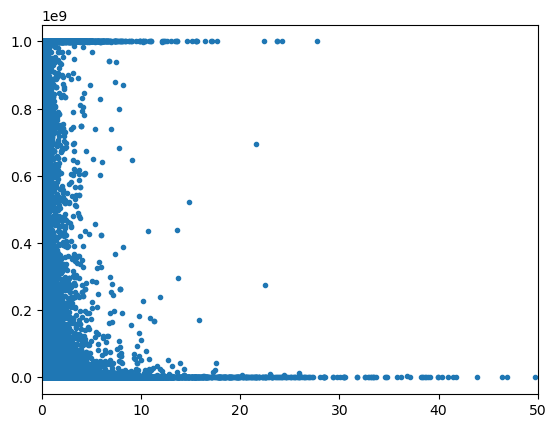

In [115]:
plt.plot(train['threeBRfillfac'],train['instability_time'], marker='.', ls = "")
ax = plt.gca()
ax.set_xlim([0, 50])